In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scipy import interpolate

def show_data(data,fit_info = (False,None,False,None),filename='',show = False,mag_only = True):
    if show:
        if mag_only:
            fig1 = plt.figure(constrained_layout = True)
            ax = fig1.add_subplot(1, 1, 1)
            ax.scatter(data['freq'],data['vmag']*data['vamp'],color='green',label=filename)
            if fit_info[0]:
                bestpars1 = fit_info[1]
                ax.plot(data['freq'],data['vamp']*(bestpars1[3]+bestpars1[4]*data['freq']+(bestpars1[2]+bestpars1[5]*data['freq'])/np.sqrt(1+4*(bestpars1[1]*(data['freq']/bestpars1[0]-1))**2)),label='Full Lorenzian Fit')
                
            if fit_info[2]:
                bestpars2 = fit_info[3]
                ax.plot(data['freq'],data['vamp']*(bestpars2[3]+bestpars2[2]/np.sqrt(1+4*(bestpars2[1]*(data['freq']/bestpars2[0]-1))**2)),label = 'Refined Fit')
            ax.legend()  
            ax.set_xlabel('Frequency (kHz)')
            ax.set_ylabel('Voltage Magnitude (mV)')
            ax.set_title('Lorenzian Fit for '+filename)
        else:
            fig0 = plt.figure(constrained_layout = True)
            ax1 = fig0.add_subplot(3, 1, 1)
            ax2 = fig0.add_subplot(3, 1, 2)
            ax3 = fig0.add_subplot(3, 1, 3)
            ax1.set_xlabel('Frequency (kHz)')
            ax2.set_xlabel('Frequency (kHz)')
            ax3.set_xlabel('Frequency (kHz)')
            ax1.set_ylabel('Vx (mV)')
            ax2.set_ylabel('Vx (mV)')
            ax3.set_ylabel('Voltage Magnitude (mV)')
            ax1.plot(data['freq'],data['vx'])
            ax2.plot(data['freq'],data['vy'])
            ax3.plot(data['freq'],data['vmag']*data['vamp'])

def cosort_lists(list_to_sort,list_to_cosort):
    out1 = np.zeros(l1 := len(list_to_sort))
    out2 = np.zeros(len(list_to_cosort))
    sorted_inds = np.argsort(np.argsort(list_to_sort))
    for i in range(l1):
        for j, ind in enumerate(sorted_inds):
            if i == ind:
                out1[i] = list_to_sort[j]
                out2[i] = list_to_cosort[j]
                break
    return out1, out2

def calc_mu(omega,sigma_x,sigma_y,length=2e-3,width=1e-3,tolerance = 1e-4):
    mu_0 = 4*np.pi*1e-7
    if width>length:
        b = length/2
        a = width/2
    else:
        a = length/2
        b = width/2
    total_sum = 0
    m = 1
    change = np.inf
    alpha_m_coef = np.pi/2/a
    gamma_m_coef = np.pi/2/b
    while np.abs(change)>tolerance:
        alpha_m = m * alpha_m_coef
        gamma_m = m * gamma_m_coef
        beta_m = np.sqrt(1j*omega*mu_0*sigma_x+alpha_m**2*sigma_x/sigma_y)
        delta_m = np.sqrt(1j*omega*mu_0*sigma_y+gamma_m**2*sigma_y/sigma_x)
        change = (np.tanh(beta_m*b)/(alpha_m*beta_m)+np.tanh(delta_m*a)/(gamma_m*delta_m))/m
        total_sum += change
        m+=2
    return total_sum*4/np.pi

def calc_power(omega,sigma_x,sigma_y,H_0,length=2e-3,width=1e-3,N_m=1,tolerance = 1e-4):
    mu = calc_mu(omega,sigma_x,sigma_y,length=length,width=width,tolerance = tolerance)
    return 1j*.5*omega*4*np.pi*1e-7*H_0*mu/(1+N_m*(mu-1))

def full_Z(omega, C1, C2, L, R):
    A = (1-L*C2*omega**2)**2 + (R*C2*omega)**2
    B = L-(R**2*C2)-(C2*(L*omega)**2)
    return R/A +1j*(omega*B/A-1/(omega*C1))

def reflection_coeff(omega, C1, C2, L, R, Z0=50):
    ZL = full_Z(omega, C1, C2,L,R)
    return (ZL/Z0-1)/(ZL/Z0+1)

def full_lorenzian_fit_with_skew(fs, f0,Q,Smax,A1,A2,A3):#fs is the data, f0 is the resonance freq
    return A1 + A2*fs + (Smax+A3*fs)/np.sqrt(1+4*(Q*(fs/f0-1))**2)#this is eq 10 from Measurement of resonant frequency and quality factor of microwave resonators: Comparison of methods Paul J. Petersan; Steven M. Anlage

def simple_lorenzian_fit(fs, f0,Q,Smax,A1):
    return A1 + Smax/np.sqrt(1+4*(Q*(fs/f0-1))**2)

def plot_polyfit(x_data,poly_coefficents):
    l = len(x_data)
    output = np.zeros(l)
    for i,a in enumerate(poly_coefficents[::-1]):
        for j in range(l):
            output[j] += a*x_data[j]**i 
    return output

def VxVyfit_2ndorderbackground(omega, C1, C2, L, R, A0, A1, A2, B0, B1, B2):
    complex_ref_coef = reflection_coeff(omega, C1, C2, L, R) +A0 +A1*omega+A2*omega**2 +1j*(B0 +B1*omega+B2*omega**2)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def VxVyfit_2ndorderbackground2(omega, C1, C2, L, R, A0, A1, A2, B0, B1, B2, D):
    complex_ref_coef = D*reflection_coeff(omega, C1, C2, L, R) +A0 +A1*omega+A2*omega**2 +1j*(B0 +B1*omega+B2*omega**2)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def VxVyfit_nobackground(omega, C1, C2, L, R,):
    complex_ref_coef = reflection_coeff(omega, C1, C2, L, R)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def quad(freq,A0,A1,A2):
    return A0 + A1*freq + A2*freq**2

def Vmagfit_2ndorderbackground(omega, C1, C2, L, R, A0, A1, A2, D):
    return D * np.abs(reflection_coeff(omega, C1, C2, L, R)) +A0 +A1*omega+A2*omega**2


In [2]:

path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/'
path_suffix = '.dat'

# filenames = [
#              'double1nf',
#             #  'double.47nf',
#             #  'double3.9nf',
#             #  '.5nfseries1nfparallel',
#             #  '2nfserise1nfparallel2',
#             #  '1nfseries3.9nfparallel'
#               ]
 

# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/InitialRandomTesting/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/LChange/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/TurnTesting/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/AfterCircCalData/ColdTest/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/BackgroundTest/'
path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/0.2nf1nFTest/'
filenames = os.listdir(path_prefix)
path_suffix = ''

data_paths = []
for f in filenames:
         data_paths.append(path_prefix + f + path_suffix)
         
datas = []
i = 0
for data in data_paths:
    try:
        all_data = np.genfromtxt(data, delimiter='\t')
        headings = np.genfromtxt(data, delimiter='\t', dtype=str, max_rows=1)
        datas.append({})
        # print(all_data)
        datas[i]['time'] = np.array(all_data[2:,0])
        datas[i]['vamp'] = float(headings[-1].split(' ')[-2])
        datas[i]['vx'] = np.array(all_data[2:,1])*-1000
        datas[i]['vy'] = np.array(all_data[2:,2])*-1000
        datas[i]['vmag'] = np.array(all_data[2:,3])*1000/datas[i]['vamp']
        datas[i]['freq'] = np.array(all_data[2:,4])
        # datas[i]['turns'] = float(filenames[i][:-9])
        i+=1
    except PermissionError:
        print("Can't read folder",data)


[ 2.28750707e-01 -4.53386185e-02  5.08625776e-03  2.47937339e-01
 -1.70194373e-01 -1.99894983e+01 -6.76873839e+00  3.33927722e+00
 -3.43061013e+00 -1.30976264e+01 -3.87314639e-03]
[ 9.83000566e-11  4.48690849e-10  2.51271564e-05  1.87190601e+01
 -6.08805764e-01 -3.24200778e-08  1.86200027e-15 -7.42107016e-02
  7.69767444e-09 -2.27695715e-16  9.96126854e-01]


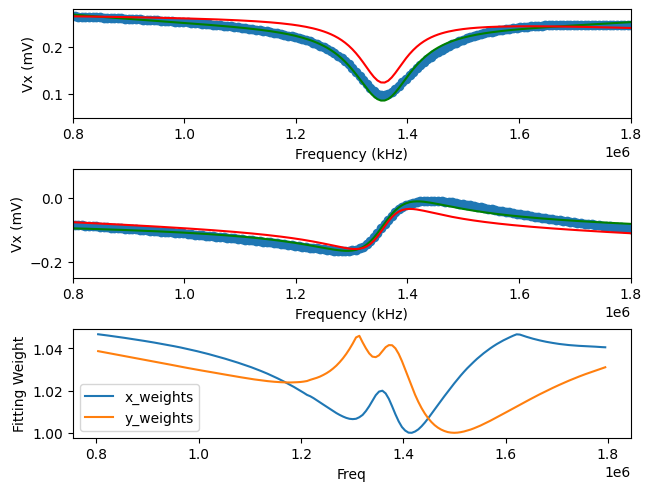

In [3]:
ind = 2


#bounds
circ_low_bounds = [1e-12,1e-12,100e-9,1]
circ_high_bounds = [10e-9,10e-9,1e-4,1e2]
background_low_bounds = [-1e1,-1e-3,-1e-8,-1e1,-1e-3,-1e-8,1e-1]
background_high_bounds = [1e1,1e-3,1e-8,1e1,1e-3,1e-8,1]

low_bounds = np.append(circ_low_bounds,background_low_bounds)
high_bounds = np.append(circ_high_bounds,background_high_bounds)
bounds = [low_bounds,high_bounds]



#prefit

# show_data(datas[ind],fit_info = (False,bestpars1,False,bestpars2),filename='',show = True, mag_only = False) #shows where the peak is

res_peak = 1.3e6
peak_width = .4e6

fitted = {}
for dat in datas[ind]:
    if dat != 'vamp':
        fitted[dat] = datas[ind][dat][np.logical_or(datas[ind]['freq']<res_peak-peak_width/2, datas[ind]['freq']>res_peak+peak_width/2)]
    else:
        fitted[dat] = datas[ind][dat]
prefit_bounds = [background_low_bounds[:3],background_high_bounds[:3]]

reflect_scalar = 1
circ_guesses = [.08e-9,.47e-9,25e-6,15] #C_par,C_ser,L,R
circ_contrib = reflect_scalar*reflection_coeff(fitted['freq']*2*np.pi,*circ_guesses)



#guesses with prefit
vx_prefit = optimize.curve_fit(quad,fitted['freq']*2*np.pi, fitted['vx']/datas[ind]['vamp']-np.real(circ_contrib),bounds=prefit_bounds)
vy_prefit = optimize.curve_fit(quad,fitted['freq']*2*np.pi, fitted['vy']/datas[ind]['vamp']-np.imag(circ_contrib),bounds=prefit_bounds)
vx_background_guesses = vx_prefit[0]
vy_background_guesses = np.append(vy_prefit[0], [reflect_scalar])

guesses = np.append(circ_guesses,np.append(vx_background_guesses,vy_background_guesses))
guess_fit = VxVyfit_2ndorderbackground2(datas[ind]['freq']*2*np.pi,*guesses)
l = len(datas[ind]['freq'])*2
vx_guess = guess_fit[:l//2]
_ = vy_guess = guess_fit[l//2:l]




fitting_range = (.8e6,1.8e6)
zoomed_inds = np.logical_and(datas[ind]['freq']>fitting_range[0],datas[ind]['freq']<fitting_range[1])

#use sharpest points as lowest uncertainty points
# grad_x = np.abs(np.gradient(datas[ind]['vx']))
# grad_y = np.abs(np.gradient(datas[ind]['vy']))
# error_approx = np.append(np.max(grad_x)-grad_x,np.max(grad_y)-grad_y)

x_diff = np.abs(vx_guess[zoomed_inds]-datas[ind]['vx'][zoomed_inds]/datas[ind]['vamp'])
y_diff = np.abs(vy_guess[zoomed_inds]-datas[ind]['vy'][zoomed_inds]/datas[ind]['vamp'])
# error_approx = x_diff+y_diff
# error_approx = np.append(np.max(x_diff)-x_diff,np.max(y_diff)-y_diff)*100
error_approx =np.append(np.exp(np.max(x_diff)-x_diff),np.exp(np.max(y_diff)-y_diff))
# for i in range(len(error_approx)):
#     if error_approx[i] <= 0:
#         error_approx[i] = error_approx[i-1]


# error_approx = np.ones(2*len(datas[ind]['freq']))

# def custom_error(input, res_peak,peak_width,ratio):
#     l = len(input)
#     output = np.zeros(l)
#     for i, freq in enumerate(input):
#         if abs(freq-res_peak)<peak_width//2:
#             output[i] = ratio
#         else:
#             output[i] = 1
#     return np.append(output,output)
# error_approx = custom_error(datas[ind]['freq'],res_peak,peak_width,5)
        
# print(bounds)
#choke bounds
percent = .25
for i in range(2):
    for j in range(4):
        bounds[i][j] = guesses[j]*(1-(-1)**i*percent)
# print(bounds)
#fit
bestfit = optimize.curve_fit(VxVyfit_2ndorderbackground2, datas[ind]['freq'][zoomed_inds]*2*np.pi, 
    np.append(datas[ind]['vx'][zoomed_inds]/datas[ind]['vamp'],datas[ind]['vy'][zoomed_inds]/datas[ind]['vamp']), 
    guesses, error_approx, bounds=bounds, maxfev=10000)
bestpars = bestfit[0]



# calc stuff for plotting
fit_info = VxVyfit_2ndorderbackground2(datas[ind]['freq']*2*np.pi,*bestpars)
l = len(fit_info)
vx_fit = fit_info[:l//2]
vy_fit = fit_info[l//2:l]



# no_circ = np.append([np.inf,0,0,0],bestpars[4:])
# sub_2nd_order = VxVyfit_2ndorderbackground(datas[ind]['freq']*2*np.pi,*no_circ)
# vy_nocirc = sub_2nd_order[l//2:l]
# vx_nocirc = sub_2nd_order[:l//2]



#Circuit Fit Plotting

fig4 = plt.figure(constrained_layout = True)
ax1 = fig4.add_subplot(3, 1, 1)
ax2 = fig4.add_subplot(3, 1, 2)
ax3 = fig4.add_subplot(3, 1, 3)
# ax1 = fig4.add_subplot(2, 1, 1)
# ax2 = fig4.add_subplot(2, 1, 2)
ax1.set_xlabel('Frequency (kHz)')
ax2.set_xlabel('Frequency (kHz)')
# ax3.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('Vx (mV)')
ax2.set_ylabel('Vx (mV)')
# ax3.set_ylabel('Voltage Magnitude (mV)')
ax1.scatter(datas[ind]['freq'],datas[ind]['vx']/datas[ind]['vamp'])
ax2.scatter(datas[ind]['freq'],datas[ind]['vy']/datas[ind]['vamp'])
# ax3.scatter(datas[ind]['freq'],datas[ind]['vmag']*datas[ind]['vamp'])
ax1.plot(datas[ind]['freq'],vx_fit,c='green')
ax2.plot(datas[ind]['freq'],vy_fit,c='green')
ax1.plot(datas[ind]['freq'],vx_guess,c='red')
ax2.plot(datas[ind]['freq'],vy_guess,c='red')

ax1.set_xlim(.8e6,1.8e6)
ax2.set_xlim(.8e6,1.8e6)
ax1.set_ylim(.05,.28)
ax2.set_ylim(-.25,.09)

# ax1.plot(datas[ind]['freq'],10*(vx_guess-datas[ind]['vx']/datas[ind]['vamp'])+np.average(vx_guess),c='black')
# ax2.plot(datas[ind]['freq'],10*(vy_guess-datas[ind]['vy']/datas[ind]['vamp'])+np.average(vy_guess),c='black')
# ax2.plot(datas[ind]['freq'],(vy_fit-datas[ind]['vy']/datas[ind]['vamp'])+np.average(vy_guess),c='purple')
# ax1.plot(datas[ind]['freq'],(vx_fit-datas[ind]['vx']/datas[ind]['vamp'])+np.average(vx_guess),c='purple')
# ax1.plot(datas[ind]['freq'],quad(datas[ind]['freq']*2*np.pi,*vx_background_guesses),c='orange')
# ax2.plot(datas[ind]['freq'],quad(datas[ind]['freq']*2*np.pi,*vy_background_guesses[:3]),c='orange')

#random auxiliary plotting
# ax3.plot(datas[ind]['freq'],error_approx[:l//2],label = 'x_weights')
# ax3.plot(datas[ind]['freq'],error_approx[l//2:l],label = 'y_weights')
ax3.set_xlabel('Freq')
ax3.set_ylabel('Fitting Weight')
l = len(error_approx)
ax3.plot(datas[ind]['freq'][zoomed_inds],error_approx[:l//2],label = 'x_weights')
ax3.plot(datas[ind]['freq'][zoomed_inds],error_approx[l//2:l],label = 'y_weights')
# ax3.plot(datas[ind]['freq'][zoomed_inds],x_diff,label = 'x_diffs')
# ax3.plot(datas[ind]['freq'][zoomed_inds],y_diff,label = 'y_diffss')
# ax3.plot(fitted['freq'],np.real(circ_contrib),label = 'x_circ-1')
# ax3.plot(fitted['freq'],np.imag(circ_contrib),label = 'y_circ')
# ax3.plot(fitted['freq'],fitted['vx']/datas[ind]['vamp']+np.real(circ_contrib),label = 'vx')
# ax3.plot(fitted['freq'],fitted['vy']/datas[ind]['vamp']+np.imag(circ_contrib),label = 'vy')
ax3.legend()
# ax3.plot(datas[ind]['freq'],vx_nocirc)
# ax3.plot(datas[ind]['freq'],vy_nocirc)
# ax3.plot(datas[ind]['freq'],np.real(reflection_coeff(datas[ind]['freq']*2*np.pi,*circ_guesses)))
# ax3.plot(datas[ind]['freq'],np.imag(reflection_coeff(datas[ind]['freq']*2*np.pi,*circ_guesses)))
# print(vx_nocirc)

_ = 1
print((bestpars-guesses)/guesses)
print(bestpars)